In [1]:
!pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import all the required libraries
# Use Kaggle's pre-tuned notebooks to get the optimal versions of all the dependencies

import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
nltk.download('stopwords')
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader

C:\Users\Rate\AppData\Local\Temp\ipykernel_4916\3082991265.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import all the required libraries
%pip install transformers
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


C:\Users\Rate\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create dataframe for final sentiment classification result
def createDataFrame(labels, confidence, tweet):
    labels = pd.DataFrame({'Labels': labels})
    confidence = pd.DataFrame({'Confidence Scores': confidence})
    column_values = ['Labels', 'Confidence']
    sentiment_scores = pd.concat([labels,confidence], ignore_index=False, axis=1)
    print("\n--------------------------------------------------------------------------------------")
    print(f"\n Entered input sentence: {tweet}")
    print("\n Sentiment of the tweet (Probability Distribution): ")
    print(sentiment_scores.to_string(index=False))
    #print("--------------------------------------------------------------------------------------")

In [5]:
def sentiment_bart(tweet):
    labels = []
    confidence = []
    
    # Possible Sentiment Categories
    candidate_labels = ["happy", "sad", "warn", "angry", "sorrow", "alert", "neutral"]
    #candidate_labels = ["OYC", "DTC", "NCF", "KNY", "DCF"]
    
    # Send the labels and tweets to the classifier pipeline
    result = classifier(tweet, candidate_labels)
    
    # Extract the labels from results dictionary
    labels.append(result["labels"])
    labels = [item for sublist in labels for item in sublist] # Flatten the list of lists into list
    
    # Extract the labels from results dictionary
    confidence.append(result["scores"])
    confidence = [(str(float(item)*100))[:6]+" %" for sublist in confidence for item in sublist] # Flatten the list of lists into list

    createDataFrame(labels,confidence, tweet)

In [6]:
# Driver program
print("Neural Sentiment Analysis of COVID-19 Tweets with BART")
print("\n------Available Options------")
print("1. Inference on Sample Tweets")
print("2. Enter Custom Tweets/Sentences")
print("3. Exit")
print("\nPlease select an option from the above:")


sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'
sentiment_bart(sample_1)
    
sample_2 = 'I am happy that my family members are safe in this tough times'
sentiment_bart(sample_2)

"""
while(True):
    choice = int(input())

    if choice == 1:
        sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'
        sentiment_bart(sample_1)
    
        sample_2 = 'I am happy that my family members are safe in this tough times'
        sentiment_bart(sample_2)
    
    elif choice == 2:
        print("\nPlease enter a sentence/tweet:")
        user_input = input()
        sentiment_bart(user_input)
    
    elif choice == 3:
        print("\nExiting...")
        break
"""

Neural Sentiment Analysis of COVID-19 Tweets with BART

------Available Options------
1. Inference on Sample Tweets
2. Enter Custom Tweets/Sentences
3. Exit

Please select an option from the above:

--------------------------------------------------------------------------------------

 Entered input sentence: Many lost their jobs because of covid and it is highly dangerous

 Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
   warn          51.956 %
  alert          26.361 %
    sad          12.751 %
 sorrow          4.9466 %
  angry          3.1605 %
neutral          0.5962 %
  happy          0.2266 %

--------------------------------------------------------------------------------------

 Entered input sentence: I am happy that my family members are safe in this tough times

 Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
  happy          76.314 %
  alert          17.165 %
   warn          3.8741 %
neutral          1.7418 %


'\nwhile(True):\n    choice = int(input())\n\n    if choice == 1:\n        sample_1 = \'Many lost their jobs because of covid and it is highly dangerous\'\n        sentiment_bart(sample_1)\n    \n        sample_2 = \'I am happy that my family members are safe in this tough times\'\n        sentiment_bart(sample_2)\n    \n    elif choice == 2:\n        print("\nPlease enter a sentence/tweet:")\n        user_input = input()\n        sentiment_bart(user_input)\n    \n    elif choice == 3:\n        print("\nExiting...")\n        break\n'

In [7]:
# Load the transfer learning tweet dataset
sentiment_df = pd.read_csv('twitterdata.csv')

In [8]:
# Checking if NVIDIA Graphics Card and CUDA is available
gpu_available = torch.cuda.is_available

if gpu_available:
    print('Parallely Processing using CUDA')
else:
    print('No CUDA Detected')

Parallely Processing using CUDA


In [80]:
# Pre-process the text and perform Stemming, Lemmatization and Stop-word removal
def text_preprocessing(text):
    remove_punctuation = [ch for ch in text if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_text


# Pad blank topken to keep the length of tweets consistent - mandatory to normalize and train the model
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)
    for i, row in enumerate(reviews_int):
        if len(row)!=0:
            features[i, -len(row):] = np.array(row)[:seq_length]
    return features

# Convert the sentences into stream of tokens
def tokenize(tweet):
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in tweet])
    return test_ints

# Predict the sentiment of the tweet - performs binary classification using the model inference
def sentiment(net, test_tweet, seq_length=50):
    print("\n--------------------------------------------------------------------------------------")
    print(f"\n Original input sentence: {test_tweet}")
    test_tweet = text_preprocessing(test_tweet)
    tokenized_tweet = tokenize(test_tweet)
    
    print(f"\n Pre-processed input sentence: {test_tweet}")
    #print(f"\nSentence converted into tokens:\n{tokenized_tweet}")

    results = {"Original": [], "Processed": [], "Sentiment": []}
    word_collection = {"Positive": [], "Negative": []}
    
    for tweets in test_tweet:
        original_tweet = tweets
        processed_tweet = text_preprocessing(tweets) 
        tokenized_tweet = tokenize(processed_tweet) 
        padded_tweet = pad_features(tokenized_tweet, seq_length)
        feature_tensor = torch.from_numpy(padded_tweet)
        
        if gpu_available:
            feature_tensor = feature_tensor.cuda()
        
        batch_size = feature_tensor.size(0)
        h = net.init_hidden(batch_size)
        output, h = net(feature_tensor, h)
        predicted_sentiment = torch.round(output.squeeze())
        
        sentiment = "Positive" if predicted_sentiment.item() == 1 else "Negative"
        results["Original"].append(original_tweet)
        results["Processed"].append(processed_tweet)
        results["Sentiment"].append(sentiment)
        word_collection[sentiment].extend(processed_tweet) 

    return results, word_collection

In [10]:
# Code block to invoke Pre-processing, Padding and Tokenization operations on the tweet

sentiment_df.loc[:, 'text'] = sentiment_df['text'].apply(text_preprocessing)

reviews_split = []
for i, j in sentiment_df.iterrows():
    reviews_split.append(j['text'])

words = []
for review in reviews_split:
    for word in review:
        words.append(word)

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word:ii for ii, word in enumerate(vocab, 1)}

encoded_reviews = []
for review in reviews_split:
    encoded_reviews.append([vocab_to_int[word] for word in review])

labels_to_int = []
for i, j in sentiment_df.iterrows():
    if j['sentiment']=='joy':
        labels_to_int.append(1)
    else:
        labels_to_int.append(0)

reviews_len = Counter([len(x) for x in encoded_reviews])
non_zero_idx = [ii for ii, review in enumerate(encoded_reviews) if len(encoded_reviews)!=0]
encoded_reviews = [encoded_reviews[ii] for ii in non_zero_idx]
encoded_labels = np.array([labels_to_int[ii] for ii in non_zero_idx])

seq_length = 50
padded_features= pad_features(encoded_reviews, seq_length)

In [11]:
# Split the dataset into Train (80%), Validation (10%) & Test (10%)
batch_size = 1
split_frac = 0.8
split_idx = int(len(padded_features)*split_frac)

training_x, remaining_x = padded_features[:split_idx], padded_features[split_idx:]
training_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

# Transform the data into a Tensor datastructure
train_data = TensorDataset(torch.from_numpy(training_x), torch.from_numpy(training_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# Prepare the dataloader for Train, Test and Validation
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

In [12]:
# Embedding Dimension of Tokens
embedding_dim = 400

# Embedding Dimension of Hidden Layers
hidden_dim = 256

# Output of the model is binary (either Positive or Negative)
output_size = 1

# Number of hidden LSTM cells
n_layers = 2
vocab_size = len(vocab_to_int)+1

In [13]:
# Structure of the Neural Network
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding_layer(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        if gpu_available:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero())
        return hidden

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

In [14]:
# Hyperparameters required for training of the network

# Learning Rate
lr = 0.001

# Loss Function - Binary Cross Entropy
criterion = nn.BCELoss()

# Gradient Descent based Optimizer - ADAM (Adaptive LR)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Number of epochs to train the model
epochs = 8
count = 0

# Step size
print_every = 200
clip = 5 

In [15]:
import torch
print(torch.__version__)


2.2.2+cu121


In [16]:
print(torch.cuda.is_available())

True


In [17]:
# Train the Neural Network
# Off-load the model to CUDA
if gpu_available:
    net.cuda()

net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        count += 1
        
        if gpu_available:
            inputs, labels = inputs.cuda(), labels.cuda()
        h = tuple([each.data for each in h])
        
        net.zero_grad()
        outputs, h = net(inputs, h)
        loss = criterion(outputs.float(), labels.float())
        
        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if count % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                
                if gpu_available:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.float(), labels.float())
            val_losses.append(val_loss.item())
        
            net.train()
            print(f"Epoch: {e+1}/{epochs}.....",f"Step: {count}.....","Train Loss: {:.6f}......".format(loss.item()),"Validation Loss: {:.6f}".format(np.mean(val_losses)))

C:\Users\Rate\AppData\Local\Temp\ipykernel_4916\1713570961.py:22: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/8..... Step: 200..... Train Loss: 0.092981...... Validation Loss: 0.102789
Epoch: 1/8..... Step: 400..... Train Loss: 0.033602...... Validation Loss: 0.174795
Epoch: 1/8..... Step: 600..... Train Loss: 0.050882...... Validation Loss: 0.072135
Epoch: 1/8..... Step: 800..... Train Loss: 0.596957...... Validation Loss: 0.893026
Epoch: 1/8..... Step: 1000..... Train Loss: 0.056181...... Validation Loss: 0.187744
Epoch: 1/8..... Step: 1200..... Train Loss: 0.544627...... Validation Loss: 0.127626
Epoch: 1/8..... Step: 1400..... Train Loss: 0.034744...... Validation Loss: 0.092830
Epoch: 1/8..... Step: 1600..... Train Loss: 0.132330...... Validation Loss: 0.126914
Epoch: 1/8..... Step: 1800..... Train Loss: 0.034075...... Validation Loss: 0.034532
Epoch: 1/8..... Step: 2000..... Train Loss: 0.032088...... Validation Loss: 0.030795
Epoch: 1/8..... Step: 2200..... Train Loss: 0.121046...... Validation Loss: 0.099969
Epoch: 1/8..... Step: 2400..... Train Loss: 0.020810...... Validation

Average Test Loss: 1.6554
Average Test Accuracy: 0.8447


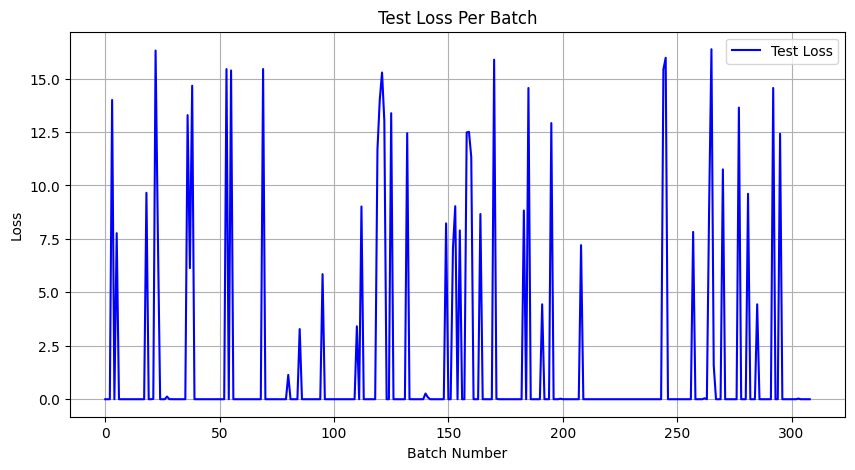

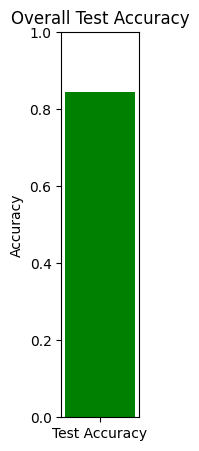

In [27]:
import matplotlib.pyplot as plt
# Train the Neural Network
test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)
net.eval()

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    
    if gpu_available:
        inputs, labels = inputs.cuda(), labels.cuda()
    
    outputs, h = net(inputs, h)
    test_loss = criterion(outputs.float(), labels.float())
    test_losses.append(test_loss.item())
    
    pred = torch.round(outputs.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


test_acc = num_correct/len(test_loader.dataset)

print("Average Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Average Test Accuracy: {:.4f}".format(test_acc))

plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Test Loss', color='blue')
plt.title('Test Loss Per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(1, 5))
plt.bar('Test Accuracy', test_acc, color='green')
plt.title('Overall Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Neural Sentiment Analysis of COVID-19 Tweets with Deep LSTM

------Available Options------
1. Inference on Sample Tweets
2. Enter Custom Tweets/Sentences
3. Exit

Please select an option from the above:

--------------------------------------------------------------------------------------

 Original input sentence: Many lost their jobs because of covid and it is highly dangerous

 Pre-processed input sentence: ['many', 'lost', 'jobs', 'covid', 'highly', 'dangerous']


C:\Users\Rate\AppData\Local\Temp\ipykernel_4916\3875549555.py:16: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentiment_counts = pd.value_counts(results["Sentiment"])
C:\Users\Rate\AppData\Local\Temp\ipykernel_4916\3875549555.py:16: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sentiment_counts = pd.value_counts(results["Sentiment"])


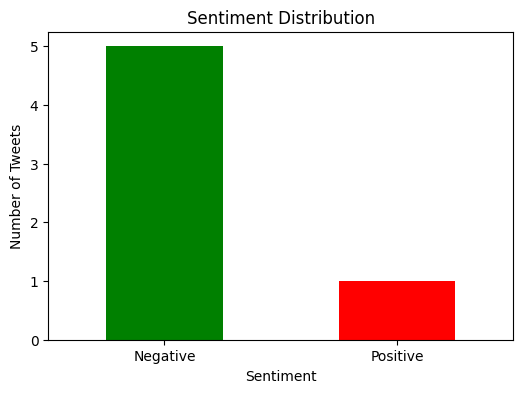

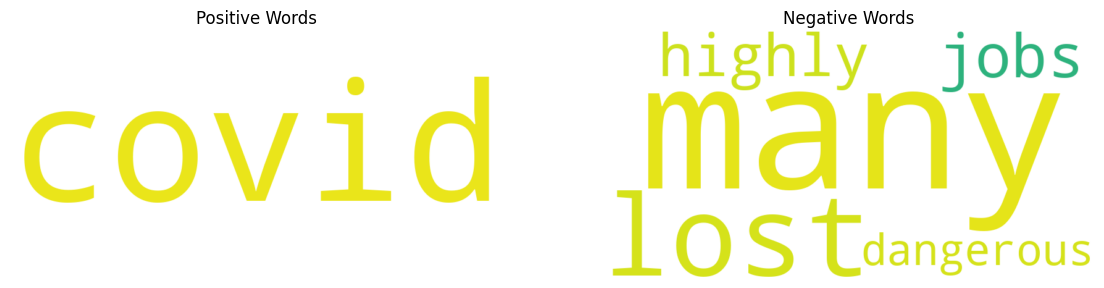

In [81]:
import matplotlib.pyplot as plt
%pip install wordcloud
from wordcloud import WordCloud

# Driver program
print("Neural Sentiment Analysis of COVID-19 Tweets with Deep LSTM")
print("\n------Available Options------")
print("1. Inference on Sample Tweets")
print("2. Enter Custom Tweets/Sentences")
print("3. Exit")
print("\nPlease select an option from the above:")

sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'

results, word_collection = sentiment(net, sample_1)
sentiment_counts = pd.value_counts(results["Sentiment"])
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()
plt.figure(figsize=(14, 7))
for i, sentiment in enumerate(['Positive', 'Negative'], 1):
    plt.subplot(1, 2, i)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_collection[sentiment]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment} Words')
    plt.axis('off')
plt.show()
